In [200]:
import CoolProp.CoolProp as CP
import os
import fortranformat as ff
import numpy as np
from multiprocessing import Pool
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class SuperHeatTable(object):
    def __init__(self,Tsh_max, Tsh_min, Psh_min, Psh_max, nT, nP, fluid):
        self.nP = nP
        self.nT = nT
        self.T_vec = np.linspace(Tsh_min, Tsh_max, nT)
        self.P_vec = np.geomspace(Psh_min, Psh_max, nP)
        self.fluid = fluid
        self.Pcrit = CP.PropsSI("PCRIT",fluid)
        self.CalcProperties()
        self.SetSubTables()
        
    def GetSuperHeatProperties(self,T,P,prop):
        if prop =='dPdv':
            v= 1/CP.PropsSI("D", 'P',P, "T", T, self.fluid)
            return CP.PropsSI("d(P)/d(D)|T", 'P',P, "T", T, self.fluid)*(-1/(v**2))
        elif prop =='v':
             return 1/CP.PropsSI("D", 'P',P, "T", T, self.fluid)
        else:
            return CP.PropsSI(prop,"P",P,"T",T,self.fluid )
        
    def GetPropMatrix(self,prop):
        matrix = []
        for p in self.P_vec:
            matrix.append(self.GetSuperHeatProperties(self.T_vec, p, prop))
        return  np.array(matrix)
        
    def GetPropArray(self,prop):
        matrix = getattr(self, prop)
        result = [item for sublist in matrix for item in sublist]
        return  result
    
    def CalcProperties(self):
        properties=["H",'A','v','CVMASS','CPMASS','dPdv','S','V',"L", 'Z']
        with Pool(5) as pool:
             matrices = pool.map(self.GetPropMatrix, properties)
        for i,p in enumerate(properties):
            setattr(self, p, matrices[i])
            
    def GetSatPropertiesVec(self,P,prop):
        result=[]
        for p in P:
            result.append(self.GetSatProperties(p, prop))
        return np.array(result)
    
    def GetSatProperties(self, P, prop):
        if P <= self.Pcrit:
            if prop =='dPdv':
                v= 1/CP.PropsSI("D", 'P',P, "Q", 1, self.fluid)
                return CP.PropsSI("d(P)/d(D)|T", 'P',P, "Q", 1, self.fluid)*(-1/(v**2))
            elif prop =='v':
                 return 1/CP.PropsSI("D", 'P',P, "Q", 1,  self.fluid)
            else:
                return CP.PropsSI(prop,"P",P, "Q",1, self.fluid)
        else:
            if prop =='dPdv':
                v= 1/CP.PropsSI("D", 'P',P, "T",self.T_vec[0], self.fluid)
                return CP.PropsSI("d(P)/d(D)|T", 'P',P, "T",self.T_vec[0], self.fluid)*(-1/(v**2))
            elif prop =='v':
                 return 1/CP.PropsSI("D", 'P',P, "T",self.T_vec[0],  self.fluid)
            else:
                return CP.PropsSI(prop,"P",P, "T",self.T_vec[0], self.fluid)
    
    def SetSubTables(self):
        properties = ['H','A','v','CVMASS','CPMASS','dPdv','S','V','L']
        with Pool(5) as pool:
            pool.map(self.SetSubTable, properties)

        
    def SetSubTable(self, prop):
        d={'H':1,'A':2,'v':3,'CVMASS':4,'CPMASS':5,'dPdv':6,'S':7,'V':8,'L':9}
        nr = d[prop]
        lines=[]
        w = ff.FortranRecordWriter('(3ES17.7E3)')
        lines.append("$TABLE_"+str(nr))
        lines.append("{:10d}".format(self.nT)+"{:10d}".format(self.nP))
        lines.append(w.write(self.T_vec))
        lines.append(w.write(self.P_vec))
        print("writing properties")
        lines.append(w.write(self.GetPropArray(prop)))
        print("writing sat properties T")
        lines.append(w.write(self.GetSatPropertiesVec(self.P_vec, "T")))
        print("writing properties "+prop)
        lines.append(w.write(self.GetSatPropertiesVec(self.P_vec, prop)))
        setattr(self, "subtable_"+prop, lines)
        return
            
    def GetSubTable(self, prop):
        return getattr(self,"subtable_"+prop)
    
    def GetHeader(self, RGP_table):
        l = []
        l.append("$$$$DATA")
        l.extend(RGP_table._GetSharedHeader())
        l.append("$$SUPER_TABLE")
        l.append("{:10d}".format(9))
        return l
    
    def GetTable(self, RGP_table):
        lines = self.GetHeader(RGP_table)
        lines.extend(self.GetSubTable( 'H'))
        lines.extend(self.GetSubTable( 'A'))
        lines.extend(self.GetSubTable( 'v'))
        lines.extend(self.GetSubTable( 'CVMASS'))
        lines.extend(self.GetSubTable( 'CPMASS'))
        lines.extend(self.GetSubTable( 'dPdv'))
        lines.extend(self.GetSubTable( 'S'))
        lines.extend(self.GetSubTable( 'V'))
        lines.extend(self.GetSubTable( 'L'))
        return lines
        

In [3]:
class SaturationTable(object):
    def __init__(self,Tsat_max, Tsat_min, npoints,fluid):
        self.npoints= npoints
        self.T_vec = np.linspace(Tsat_min, Tsat_max, npoints)
        self.fluid = fluid
        self.CalcProp()
    
    def CalcProp(self):
        self.Psat = CP.PropsSI("P",          'T',self.T_vec, "Q",1,self.fluid) 
        self.Hl   = CP.PropsSI("H",          'T',self.T_vec, "Q",0, self.fluid)
        self.cpl  = CP.PropsSI("CPMASS",     'T',self.T_vec, "Q",0, self.fluid)
        self.dDdPl= CP.PropsSI("d(D)/d(P)|T",'T',self.T_vec, "Q",0, self.fluid)
        self.Sl   = CP.PropsSI("S",          'T',self.T_vec, "Q",0, self.fluid)
        self.Cvl  = CP.PropsSI("CVMASS",     'T',self.T_vec, "Q",0, self.fluid)
        self.Al   = CP.PropsSI("A",          'T',self.T_vec, "Q",0, self.fluid)
        self.Vl   = CP.PropsSI("V",          'T',self.T_vec, "Q",0, self.fluid)
        self.Ll   = CP.PropsSI("L",          'T',self.T_vec, "Q",0, self.fluid)
        self.Hg   = CP.PropsSI("H",          'T',self.T_vec, "Q",1, self.fluid)
        self.cpg  = CP.PropsSI("CPMASS",     'T',self.T_vec, "Q",1, self.fluid)
        self.dDdPg= CP.PropsSI("d(D)/d(P)|T",'T',self.T_vec, "Q",1, self.fluid)
        self.Sg   = CP.PropsSI("S",          'T',self.T_vec, "Q",1, self.fluid)
        self.Cvg  = CP.PropsSI("CVMASS",     'T',self.T_vec, "Q",1, self.fluid)
        self.Ag   = CP.PropsSI("A",          'T',self.T_vec, "Q",1, self.fluid)
        self.Vg   = CP.PropsSI("V",          'T',self.T_vec, "Q",1, self.fluid)
        self.Lg   = CP.PropsSI("L",          'T',self.T_vec, "Q",1, self.fluid)
        
    def GetHeader(self):
        lines=[]
        lines.append("$$SAT_TABLE")
        lines.append("{:10d}".format(self.npoints)+"{:10d}".format(4)+"{:10d}".format(9))
        return lines
        
    def GetValues(self):
        w = ff.FortranRecordWriter('(3ES17.7E3)')
        lines = []
        lines.append(w.write(self.Psat))
        lines.append(w.write(self.T_vec))
        lines.append(w.write([0]*len(self.T_vec)))
        lines.append(w.write([0]*len(self.T_vec)))
        lines.append(w.write(self.Hl))
        lines.append(w.write(self.cpl))
        lines.append(w.write(self.dDdPl))
        lines.append(w.write(self.Sl))
        lines.append(w.write(self.Cvl))
        lines.append(w.write(self.Al))
        lines.append(w.write(self.Vl))
        lines.append(w.write(self.Ll))
        lines.append(w.write(self.Hg))
        lines.append(w.write(self.cpg))
        lines.append(w.write(self.dDdPg))
        lines.append(w.write(self.Sg))
        lines.append(w.write(self.Cvg))
        lines.append(w.write(self.Ag))
        lines.append(w.write(self.Vg))
        lines.append(w.write(self.Lg))
        return lines
            
    def GetTable(self):
        lines = self.GetHeader()
        lines.extend(self.GetValues())
        return lines


In [4]:
class RGPTable(object):
    def __init__(self, Tsh_max, Tsh_min, Psh_min, Psh_max, Tsat_max, Tsat_min,nT, nP,nSat, fluid):
        self.fluid=fluid
        self.Tsh_max=Tsh_max
        self.Tsh_min=Tsh_min
        self.Psh_max=Psh_max
        self.Psh_min=Psh_min
        self.Tsat_max=Tsat_max
        self.Tsat_min=Tsat_min
        self.P_crit=CP.PropsSI("PCRIT",self.fluid)
        self.P_triple=CP.PropsSI("PTRIPLE",self.fluid)
        self.T_crit=CP.PropsSI("TCRIT",self.fluid)
        self.T_triple=CP.PropsSI("TTRIPLE",self.fluid)

        self.nT=nT
        self.nP=nP
        
        
        self.SHTable = SuperHeatTable(Tsh_max, Tsh_min, Psh_min, Psh_max, nT, nP, fluid)
        self.SatTable = SaturationTable(Tsat_max,Tsat_min, nSat,fluid)
    
    def GetTable(self):
        l = self.GetHeader()
        l.extend(self.SHTable.GetTable(self))
        l.extend(self.SatTable.GetTable())
        return l
        
        
    def GetHeader(self):
        l=[]
        l.append("$$$$HEADER")
        l.extend(self._GetSharedHeader())
        return l
    
    def _GetSharedHeader(self):
        l=[]
        l.append("$$$"+self.fluid)
        l.append("{:10d}".format(1))
        l.append("$$PARAM")
        l.append("{:10d}".format(26)) #integer (number of parameters)
        l.append("DESCRIPTION") 
        l.append(self.fluid+" from CoolProp") #character*50 (description of the material)    
        l.append("NAME") 
        l.append(self.fluid) #(material name, same as $$$<component>
        l.append("INDEX")
        l.append(self.fluid)
        l.append("DATABASE") 
        l.append("CoolProp")
        l.append("MODEL")
        l.append("{:10d}".format(3))
        l.append("UNITS") 
        l.append("{:10d}".format(1))
        l.append("PMIN_SUPERHEAT")
        l.append("{:23.16e}".format(self.Psh_min))
        l.append("PMAX_SUPERHEAT")
        l.append("{:23.16e}".format(self.Psh_max))
        l.append("TMIN_SUPERHEAT")
        l.append("{:23.16e}".format(self.Tsh_min))
        l.append("TMAX_SUPERHEAT")
        l.append("{:23.16e}".format(self.Tsh_max))
        l.append("TMIN_SATURATION")
        l.append("{:23.16e}".format(self.Tsat_min))
        l.append("TMAX_SATURATION")
        l.append("{:23.16e}".format(self.Tsat_max))
        l.append("SUPERCOOLING")                  
        l.append("{:23.16e}".format(0))
        l.append("P_CRITICAL")
        l.append("{:23.16e}".format(self.P_crit))
        l.append("P_TRIPLE")
        l.append("{:23.16e}".format(self.P_triple))
        l.append("T_CRITICAL")
        l.append("{:23.16e}".format(self.T_crit))
        l.append("T_TRIPLE")
        l.append("{:23.16e}".format(self.T_triple))
        for i in range(1,10):
            l.append("TABLE_"+str(i))
            l.append("{:10d}".format(self.nT)+"{:10d}".format(self.nP))
        l.append("SAT_TABLE")
        l.append("{:10d}".format(5)+"{:10d}".format(4)+"{:10d}".format(9))
        return l
    
    
    def WriteTable(self, filename):
        table=self.GetTable()
        with open(filename, 'w') as f:
            for line in table:
                f.write(line + os.linesep)
        
    
    
# table = RGPTable(400, 240, 55000, 400000,350,240,  5, 5,5, "R134a")
# table.WriteTable(table.fluid+".rgp")


In [5]:
table = RGPTable(700, 300, 1e3, 50e5, \
                 CP.PropsSI("T","P",41e5, 'Q',1, "Toluene"), \
                 CP.PropsSI("T","P",1e4, 'Q',1, "Toluene"), \
                 100, 100,100, "Toluene")




writing properties
writing propertieswriting properties
writing propertieswriting properties


writing sat properties T
writing properties A
writing properties
writing sat properties T
writing sat properties T
writing sat properties T
writing sat properties Twriting properties v
writing properties H

writing properties CVMASS
writing properties CPMASS
writing properties
writing properties
writing properties
writing sat properties T
writing properties dPdv
writing sat properties T
writing sat properties T
writing properties S
writing properties L
writing sat properties T
writing properties V


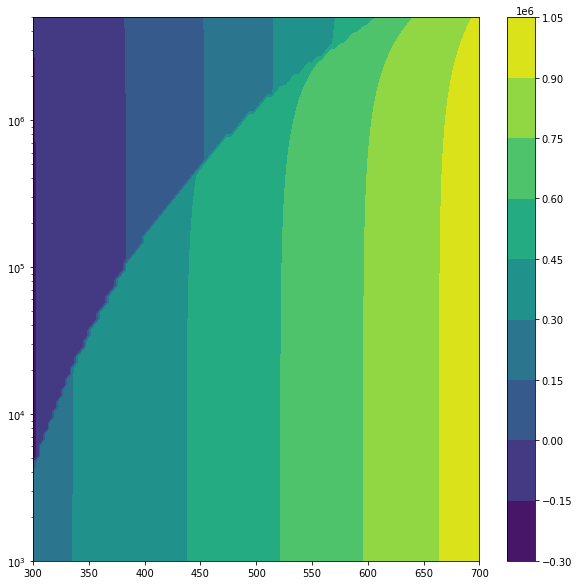

In [201]:
x = table.SHTable.T_vec
y = table.SHTable.P_vec

X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.contourf(X, Y, table.SHTable.H)
ax.set_yscale('log')
fig.colorbar(im, ax=ax)
plt.show()

## Table picture

In [202]:
Pmax=2e7
Pmin=1e2
Tmin=200
Tmax=800
P = np.geomspace(Pmin,Pmax,500)
T = np.linspace(Tmin,Tmax,500)
Tvg =np.linspace(CP.PropsSI("T","P",P[0],"Q",0,'Toluene'),CP.PropsSI("Tcrit",'Toluene'),100 )
Pvg = [CP.PropsSI("P","T",t,"Q",0,'Toluene') for t in Tvg]

In [203]:
CP.PropsSI("T","P",P[0],"Q",0,'Toluene')

242.99137118798254

In [204]:
Z=[]
for p in P:
    Z.append([CP.PropsSI("Z","P",p, 'T', t, 'Toluene') for t in T])
vg = [[CP.PropsSI("Z","P",p, 'T', t, 'Toluene') for t in T]]

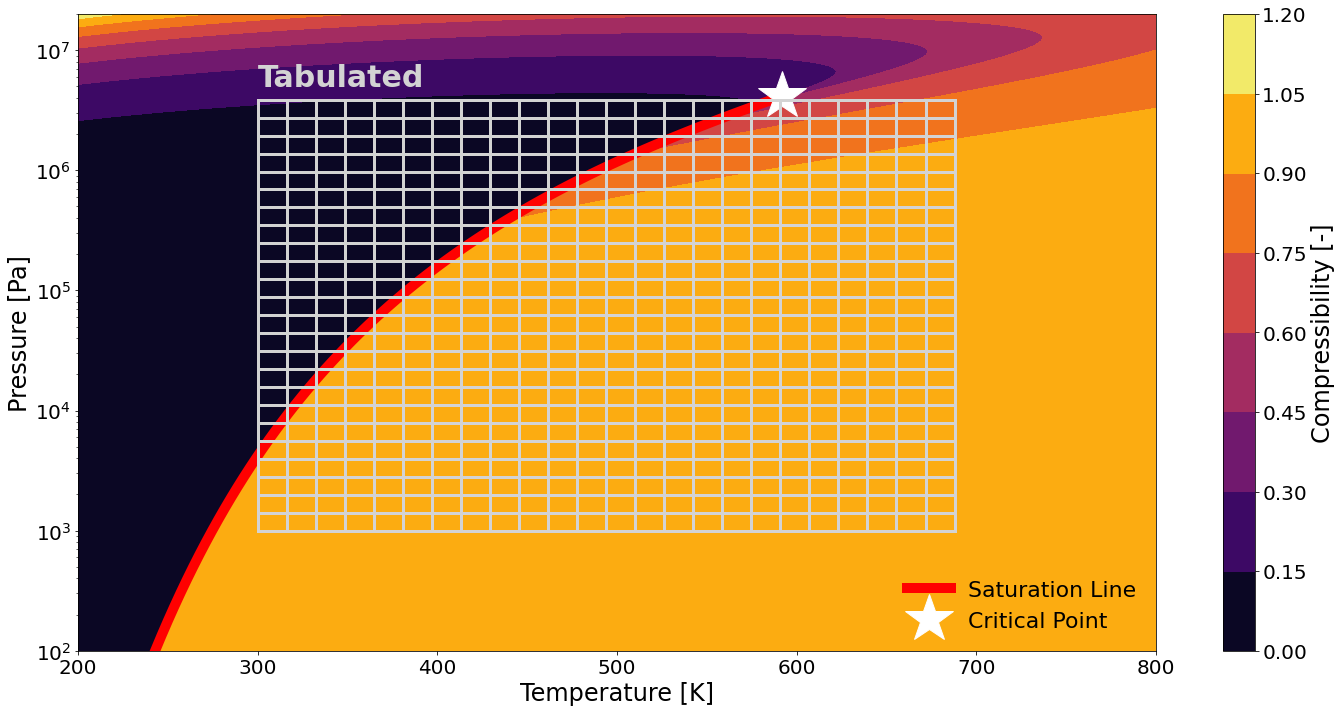

In [206]:
fig, ax = plt.subplots(figsize=(20,10))

X, Y = np.meshgrid(T, P)
im = ax.contourf(T, P, Z,cmap='inferno')
ax.set_yscale('log')
cb = fig.colorbar(im, ax=ax)
ax.set_yscale('log')
ax.set_xlabel("Temperature [K]",fontsize=24)
ax.set_ylabel("Pressure [Pa]",fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
cb.set_label("Compressibility [-]",fontsize=24)
cb.ax.tick_params(labelsize=20)
ax.plot(Tvg,Pvg, color='r', linewidth=10, label='Saturation Line')
ax.plot(CP.PropsSI("Tcrit",'Toluene'),CP.PropsSI("Pcrit",'Toluene'), marker='*', markersize=50, color='white',linestyle="None", label='Critical Point')
# fig, ax = plt.subplots(figsize=(20,10))
for i in table.SHTable.P_vec[::4]:
    ax.plot([table.SHTable.T_vec[0],table.SHTable.T_vec[-4]],[i,i], color='lightgrey',linewidth=3)
for i in table.SHTable.T_vec[::4]:
    ax.plot([i,i],[table.SHTable.P_vec[0],table.SHTable.P_vec[-4]], color='lightgrey',linewidth=3)
ax.legend(loc=4,prop={'size': 22}, framealpha=0)
style = dict(size=30, color='lightgrey', fontweight='bold')
ax.text(300, 5e6, "Tabulated", **style)
plt.tight_layout()
fig.savefig('table.png')
fig.savefig('table.svg')
